# Project 03 - Recommender Systems

-   Date: Feb 26th
-   Group Members: 
  - Guanyu Qian (UID: 606076335) 
  - Hanyi Duan (UID: 806073864)
  - Yifan Zhong (UID: 705507868)


In [1]:
#data reading 
from google.colab import drive
drive.mount('/content/drive')

######## Q1
import os
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6) # adjust fig size *for all figs*
import numpy as np

######## Q5
%pip install surprise
from surprise import Dataset, accuracy
from surprise.reader import Reader
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.similarities import pearson
from surprise.model_selection import cross_validate

######## Q6
from sklearn.metrics import roc_curve, roc_auc_score
from surprise.model_selection import KFold, train_test_split
from sklearn import metrics

######## Q8-9
from surprise import NMF

######## Q10
from surprise import SVD

######## Q11
from surprise import Prediction

######## Q14
from collections import defaultdict

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 KB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp38-cp38-linux_x86_64.whl size=3366573 sha256=5555bc348e87dfc5a3033f25b514f4ab36caa15204c18d7aa7c2ea65c2c9f796
  Stored in directory: /root/.cache/pip/wheels/af/db/86/2c18183a80ba05da35bf0fb7417aac5cddbd93bcb1b92fd3ea
Successfully built scikit-surprise


In [ ]:
# convert dataframe to dataset to use in surprise
def dataframe_to_dataset(dataframe):
  reader = Reader(rating_scale=(0, 5))
  dataset = Dataset.load_from_df(dataframe[["userId", "movieId", "rating"]], reader)
  return dataset

# Dataset

In [2]:
directory = '/content/drive/MyDrive/ECE 219/Project 3/Synthetic_Movie_Lens'

rating = 'ratings.csv'

movie_rating_file = os.path.join(directory, rating)

df = pd.read_csv(movie_rating_file)

display(df)

,Unnamed: 0,userId,movieId,rating,timestamp
0,0,496,112852,3.0,1415520462
1,1,391,1947,4.0,1030945141
2,2,387,1562,1.5,1095041022
3,3,474,2716,4.5,1053020930
4,4,483,88125,4.5,1311337237
...,...,...,...,...,...
100831,100831,469,1219,4.0,965661925
100832,100832,599,3571,2.0,1498511343
100833,100833,414,276,3.0,961596299
100834,100834,395,168,3.0,841503984


In [ ]:
directory = '/content/drive/MyDrive/ECE 219/Project 3/Synthetic_Movie_Lens'

movie_genre = 'movies.csv'

movie_genre_file = os.path.join(directory, movie_genre)

movie_df = pd.read_csv(movie_genre_file)

display(movie_df)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [ ]:
num_of_user = df['userId'].nunique() #repeated id removed
num_of_movie = df['movieId'].nunique() #repeated id removed

possible_rating = num_of_user * num_of_movie

available_rating = len(df)

sparsity = available_rating / possible_rating 

print("The sparsity of the movie rating dataset is: ", sparsity)

The sparsity of the movie rating dataset is:  0.016999683055613623


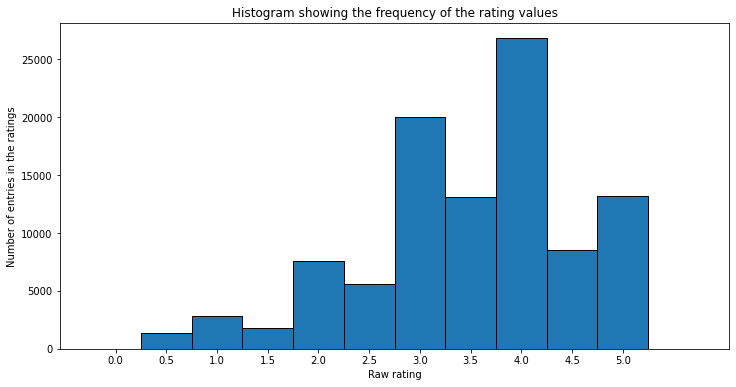

In [ ]:
plt.hist(df['rating'], bins=12, range=(-0.25, 5.75), edgecolor='black')
plt.title('Histogram showing the frequency of the rating values')
plt.xlabel('Raw rating')
plt.ylabel('Number of entries in the ratings')
plt.xticks(np.arange(0, 5.5, 0.5))
plt.show()

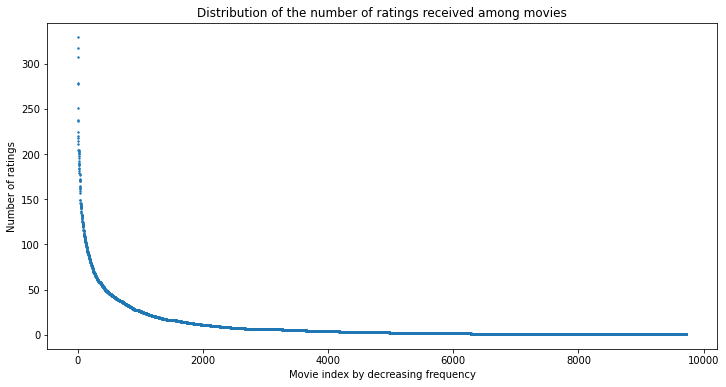

In [ ]:
movie_num_of_rating = df.groupby('movieId').size()

movie_num_of_rating_descend = movie_num_of_rating.sort_values(ascending=False)

freq = movie_num_of_rating_descend.values

movie_index = np.arange(0, len(freq), 1)

plt.scatter(movie_index, freq, s = 2)
plt.xlabel('Movie index by decreasing frequency')
plt.ylabel('Number of ratings')
plt.title('Distribution of the number of ratings received among movies')
plt.show()

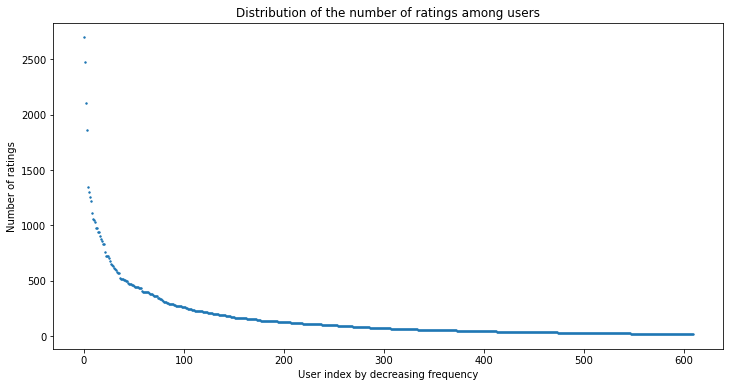

In [ ]:
user_num_of_rating = df.groupby('userId').size()

user_num_of_rating_descend = user_num_of_rating.sort_values(ascending=False)

freq = user_num_of_rating_descend.values

user_index = np.arange(0, len(freq), 1)

plt.scatter(user_index, freq, s = 2)
plt.xlabel('User index by decreasing frequency')
plt.ylabel('Number of ratings')
plt.title('Distribution of the number of ratings among users')
plt.show()

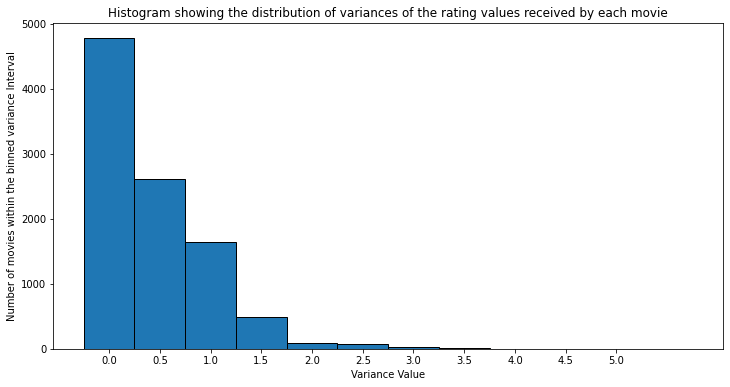

In [ ]:
rating_variance = df.groupby('movieId')['rating'].var(ddof=0)

plt.hist(rating_variance, bins=12, range=(-0.25, 5.75), edgecolor='black')
plt.title('Histogram showing the distribution of variances of the rating values received by each movie')
plt.xlabel('Variance Value')
plt.xticks(np.arange(0, rating_variance.max(), 0.5))
plt.ylabel('Number of movies within the binned variance Interval')
plt.show()

# Neighborhood-based Collaborative Filtering

__Question 2A__
$$\mu_u=\frac{1}{||I_u||}\times\sum_{k\in{I_u}}{r_{uk}}$$

__Question 2B__
- $I_u\cap I_v$ is the set of items indices for which ratings ahve been specified by both users u and v.
- Since the rating matrix $R$ is sparse, a lot of items are unrated. It is possible to have $I_u\cap I_v = ∅$.

__Question 3__

Mean-centering the raw ratings can eliminate the user bias and improve the accuracy of results. If a user's rating is significantly higher than others, mean centering will bring the rating down. If the rating is lower than the average, mean centering will bring up the rating. It helps to keep ratings from different users on a more relative scale.

## k-NN Collaborative Filter

In [ ]:
# convert pd dataframe to dataset
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df[["userId", "movieId", "rating"]], reader)

In [ ]:
RMSEs = []
MAEs = []

for k in range(2, 102, 2):
    predictor = KNNWithMeans(k=k, sim_options={'name': 'pearson'})
    results = cross_validate(predictor, data, cv=10) # set cv = 10 to perform 10-fold cross-validation
    RMSEs.append(np.average(results['test_rmse']))
    MAEs.append(np.average(results['test_mae']))

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

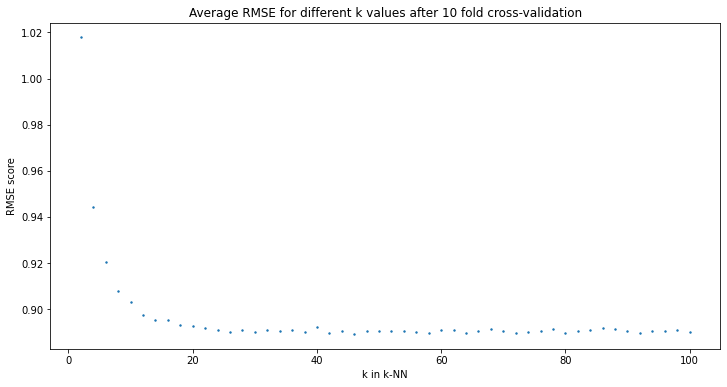

In [ ]:
k_values = np.arange(2, 102, 2)

plt.scatter(k_values, RMSEs, s = 2)
plt.xlabel('k in k-NN')
plt.ylabel('RMSE score')
plt.title('Average RMSE for different k values after 10 fold cross-validation')
plt.show()

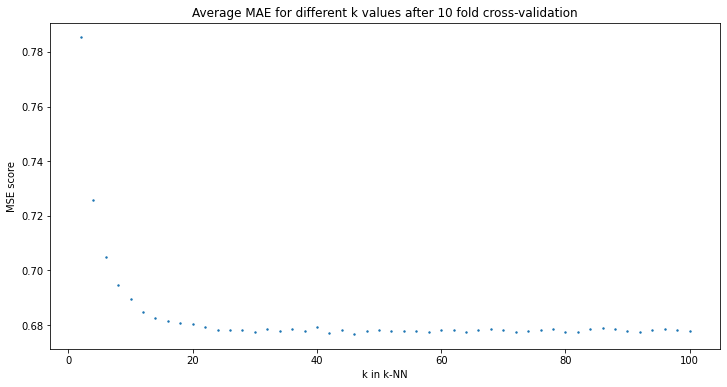

In [ ]:
plt.scatter(k_values, MAEs, s = 2)
plt.xlabel('k in k-NN')
plt.ylabel('MAE score')
plt.title('Average MAE for different k values after 10 fold cross-validation')
plt.show()

__Question 5__

The minimum k value is 20. The steady state average RMSE is approximately 0.89 and the steady state average MAE is approximately 0.68.

## Filter Model Performance Based on Subset of the Raw Data

In [ ]:
# Popular movie trimming
def trimming_popular_movie(data):
    trimmed_data = data.groupby("movieId").filter(lambda x : len(x) > 2)
    return trimmed_data

# Unpopular movie trimming
def trimming_unpopular_movie(data):
    trimmed_data = data.groupby("movieId").filter(lambda x : len(x) <= 2)
    return trimmed_data

# High variance movie trimming
def trimming_high_variance_movie(data):
    trimmed_data = data.groupby("movieId").filter(lambda x : len(x) >= 5) # filter out movies with rating count < 5
    trimmed_data['var'] = trimmed_data.groupby('movieId')['rating'].var(ddof=0) # add a column denote the var
    trimmed_data = trimmed_data[trimmed_data['var'] >= 2]
    return trimmed_data

def filter_rating(rating, threshold):
  if rating >= threshold:
    return 1 
  else:
    return 0 


# plot the ROC curve and return AUC score
def plot_ROC_curve(y_true_labels, y_scores, label, title,color="blue", pos_label=2):
    fpr, tpr, _ = metrics.roc_curve(y_true_labels, y_scores) # pos_label 1 implies that the user likes the movie
    try:
      auc = roc_auc_score(y_true_labels, y_scores)
    except ValueError:
      auc = 'N/A'

    # auc = roc_auc_score(y_true_labels, y_scores)
    plt.plot(fpr,tpr,color=color, label=label+' Area under the curve : '+ str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(title)
    plt.legend()
    
    return auc

def plot_RMSE_k_fold_cross_validation(name, dataset, k_values):
    trimmed_avg_RMSEs = []
    for k in k_values:
      kf = KFold(n_splits = 10)
      trimmed_RMSEs = []
      for trainset, testset in kf.split(dataset):
        collaborative_filter = KNNWithMeans(k=k, sim_options=sim_options)
        collaborative_filter.fit(trainset)
        predictions = collaborative_filter.test(testset)
        trimmed_RMSEs.append(accuracy.rmse(predictions, verbose=False))
      trimmed_avg_RMSEs.append(sum(trimmed_RMSEs) / len(trimmed_RMSEs))

    plt.scatter(k_values, trimmed_avg_RMSEs, s = 2)
    plt.xlabel('k in k-NN')
    plt.ylabel('RMSE score')
    plt.title('Average RMSE for different k values after 10-fold cross-validation on ' + dataset_name)
    plt.show()
    return min(trimmed_avg_RMSEs)

---

In [ ]:
# trimming the data with different settings
popular_movie_df = trimming_popular_movie(df)
unpopular_movie_df = trimming_unpopular_movie(df)
high_variance_movie_df = trimming_high_variance_movie(df)

untrimmed_movie_data = dataframe_to_dataset(df)
popular_movie_date = dataframe_to_dataset(popular_movie_df)
unpopular_movie_date = dataframe_to_dataset(unpopular_movie_df)
high_variance_movie_date = dataframe_to_dataset(high_variance_movie_df)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

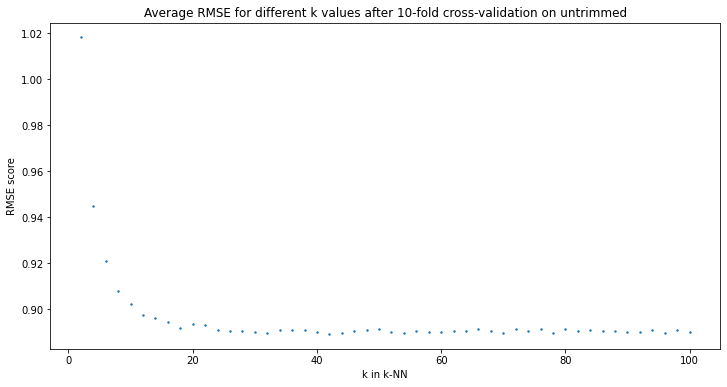

The minimum average RMSE is 0.8891417657120485
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similar

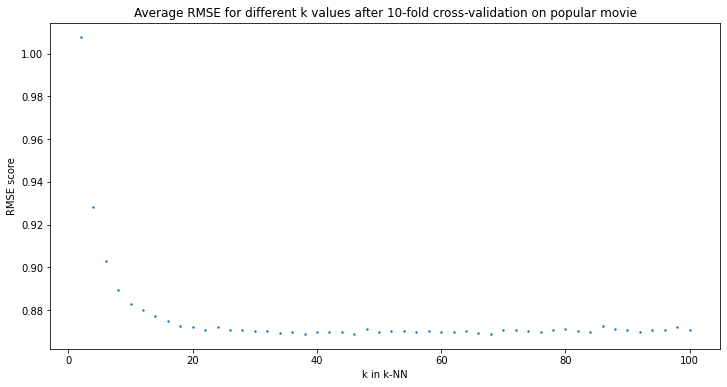

The minimum average RMSE is 0.868761624647077
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similari

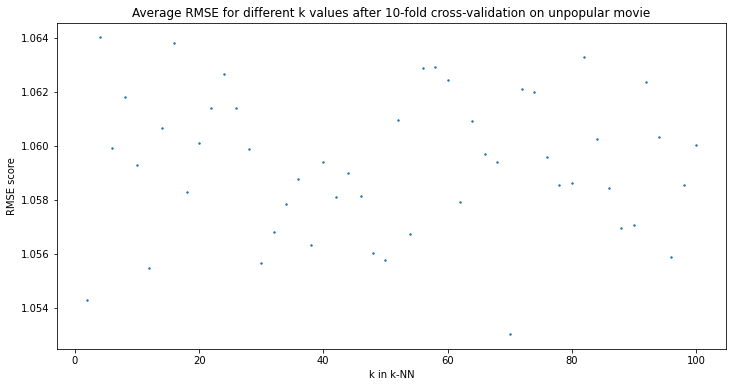

The minimum average RMSE is 1.0530222860498175
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similar

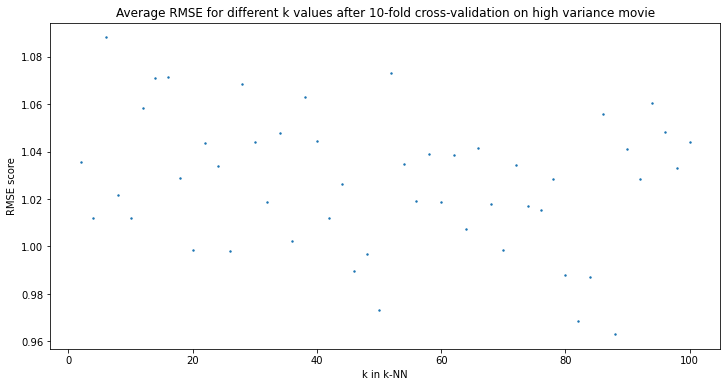

The minimum average RMSE is 0.9631475093020967


In [ ]:
sim_options = {'name': 'pearson'}

k_values = range(2, 102, 2)

datasets = {"untrimmed": untrimmed_movie_data,
            "popular movie": popular_movie_date,
            "unpopular movie": unpopular_movie_date,
            "high variance movie": high_variance_movie_date}

for dataset_name in datasets:
  dataset = datasets[dataset_name]

  # plot 10-fold cross validation RMSE
  min_RMSE = plot_RMSE_k_fold_cross_validation(dataset_name, dataset, k_values)
  print("The minimum average RMSE is", min_RMSE)

In [ ]:
thresholds = [2.5, 3, 3.5, 4]
colors = ['blue','red','green','purple']
labels = ['threshold = 2.5', 'threshold = 3 ', 'threshold = 3.5', 'threshold = 4']
datasets_roc = {"original movie": untrimmed_movie_data,
            "popular movie": popular_movie_date,
            "unpopular movie": unpopular_movie_date,
            "high variance movie": high_variance_movie_date}

def trimmed_dataset_ROC_curves(name, dataset, labels, thresholds, colors):
  for i in range(4):
    threshold = thresholds[i]
    trainset, testset = train_test_split(dataset, test_size=0.1)

    collaborative_filter = KNNWithMeans(k=20, sim_options={'name': 'pearson'})

    predictions = collaborative_filter.fit(trainset).test(testset)
    
    y_true_labels = []
    y_scores = []

    for prediction in predictions:
      y_true_labels.append(filter_rating(rating=prediction.r_ui, threshold = threshold))
      y_scores.append(prediction.est)

    plot_ROC_curve(y_true_labels, y_scores, labels[i], "ROC curve for " + name + " dataset", color=colors[i], pos_label=2)
  plt.show()

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


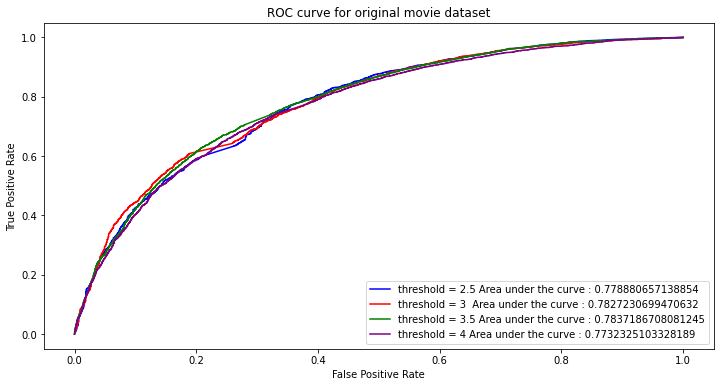

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


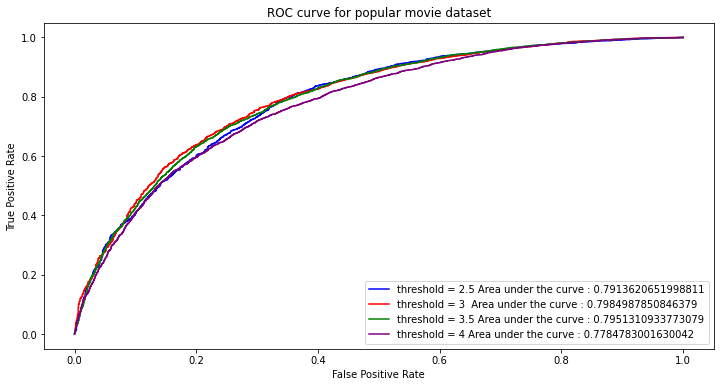

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


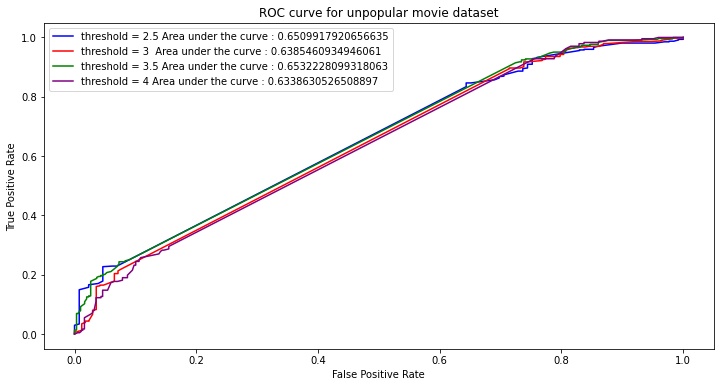

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


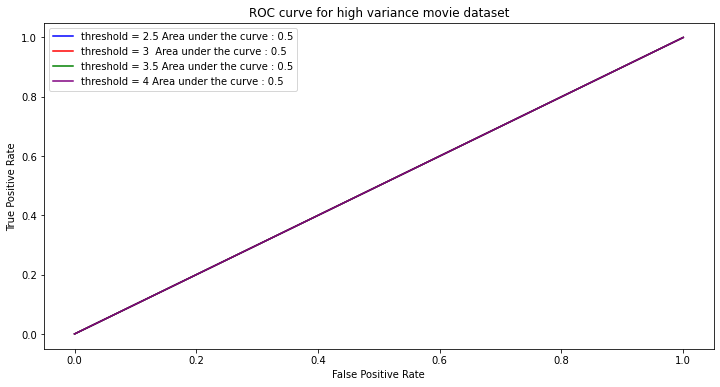

In [ ]:
trimmed_dataset_ROC_curves("original movie", untrimmed_movie_data, labels, thresholds, colors)
trimmed_dataset_ROC_curves("popular movie", popular_movie_date, labels, thresholds, colors)
trimmed_dataset_ROC_curves("unpopular movie", unpopular_movie_date, labels, thresholds, colors)
trimmed_dataset_ROC_curves("high variance movie", high_variance_movie_date, labels, thresholds, colors)

# Model-based collaborative filtering

In [ ]:
directory = '/content/drive/MyDrive/ECE 219/Project 3/Synthetic_Movie_Lens'

rating = 'ratings.csv'

movie_rating_file = os.path.join(directory, rating)

df = pd.read_csv(movie_rating_file)



pop_movie_df = trimming_popular_movie(df)

unpop_movie_df = trimming_unpopular_movie(df)

high_movie_df = trimming_high_variance_movie(df)

In [ ]:
pop_movie_data = dataframe_to_dataset(pop_movie_df)

unpop_movie_data = dataframe_to_dataset(unpop_movie_df)

high_movie_data = dataframe_to_dataset(high_movie_df)

In [ ]:
reader = Reader(rating_scale=(0, 5))

data = Dataset.load_from_df(df[["userId", "movieId", "rating"]], reader)


In [ ]:
# sweep k in 10-fold cv
k_value = np.arange(2, 51, 2)

#kf = KFold(n_splits = 10) 

rmse_nmf = []

mae_nmf = []


for k in k_value:
  algo = NMF(n_factors=k)
  cv_10f = cross_validate(algo=algo, data=data, measures=['rmse', 'mae'], cv=10, verbose=False)
  rmse_nmf.append(cv_10f['test_rmse'].mean())
  mae_nmf.append(cv_10f['test_mae'].mean())



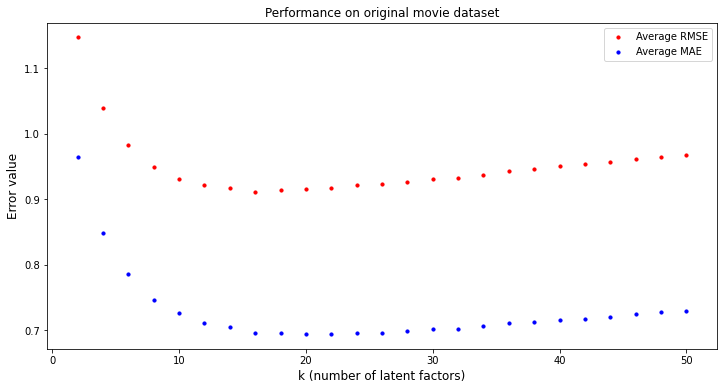

In [ ]:
plt.scatter(k_value, rmse_nmf, label='Average RMSE', color="red", s = 10)

plt.scatter(k_value, mae_nmf, label='Average MAE', color="blue", s = 10)

plt.xlabel('k (number of latent factors)',fontsize=12)

plt.ylabel('Error value',fontsize=12)

plt.title("Performance on original movie dataset")

plt.legend()

plt.show()

In [ ]:
#optimal k based on rsme
for i in range (len(rmse_nmf)):
  if rmse_nmf[i] == min(rmse_nmf):
    k_opt = k_value[i]

print("The optimal number of latent factors (based on RSME) is: ",k_opt)


#optimal k based on mae
for i in range (len(mae_nmf)):
  if mae_nmf[i] == min(mae_nmf):
    k_opt = k_value[i]


print("The optimal number of latent factors (based on MAE) is: ",k_opt)

#### calculate the numbers of genre
genre_list = movie_df['genres'].str.split('|')

unique_genre = set()

for i in genre_list:
    for j in i:
        unique_genre.add(j)
print("The number of movie genres is: ", len(unique_genre))

The optimal number of latent factors (based on RSME) is:  16
The optimal number of latent factors (based on MAE) is:  22
The number of movie genres is:  20


In [ ]:
# sweep k in 10-fold cv.  popular movie
k_value = np.arange(2, 51, 2)

#kf = KFold(n_splits = 10) 

rmse_nmf_pop = []



for k in k_value:
  algo = NMF(n_factors=k)
  cv_10f = cross_validate(algo=algo, data=pop_movie_data, measures=['rmse'], cv=10, verbose=False)
  rmse_nmf_pop.append(cv_10f['test_rmse'].mean())


Minium average RSME is :  0.8909788154965529




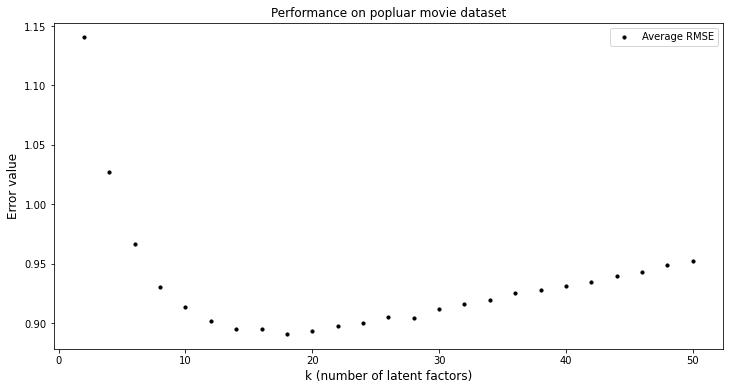

In [ ]:
print("Minimum average RSME is : ", min(rmse_nmf_pop))

print("\n")

plt.scatter(k_value, rmse_nmf_pop, label='Average RMSE', color="black", s = 10)


plt.xlabel('k (number of latent factors)',fontsize=12)

plt.ylabel('Error value',fontsize=12)

plt.title("Performance on popluar movie dataset")

plt.legend()

plt.show()

In [ ]:
# sweep k in 10-fold cv.  unpopular movie
k_value = np.arange(2, 51, 2)

#kf = KFold(n_splits = 10) 

rmse_nmf_unpop = []



for k in k_value:
  algo = NMF(n_factors=k)
  cv_10f = cross_validate(algo=algo, data=unpop_movie_data, measures=['rmse'], cv=10, verbose=False)
  rmse_nmf_unpop.append(cv_10f['test_rmse'].mean())

Minium average RSME is :  1.1316253566982986




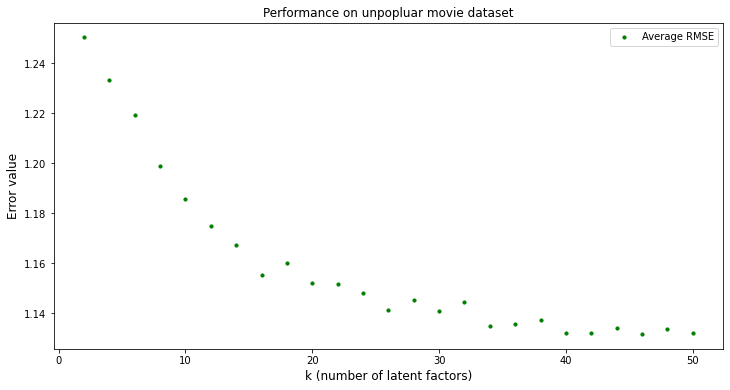

In [ ]:
print("Minimum average RSME is : ", min(rmse_nmf_unpop))

print("\n")

plt.scatter(k_value, rmse_nmf_unpop, label='Average RMSE', color="green", s = 10)


plt.xlabel('k (number of latent factors)',fontsize=12)

plt.ylabel('Error value',fontsize=12)

plt.title("Performance on unpopluar movie dataset")

plt.legend()

plt.show()

In [ ]:
# sweep k in 10-fold cv.  high variance movie
k_value = np.arange(2, 51, 2)

#kf = KFold(n_splits = 10) 

rmse_nmf_high = []



for k in k_value:
  algo = NMF(n_factors=k)
  cv_10f = cross_validate(algo=algo, data=high_movie_data, measures=['rmse'], cv=10, verbose=False)
  rmse_nmf_high.append(cv_10f['test_rmse'].mean())


Minium average RSME is :  0.9956427084815829




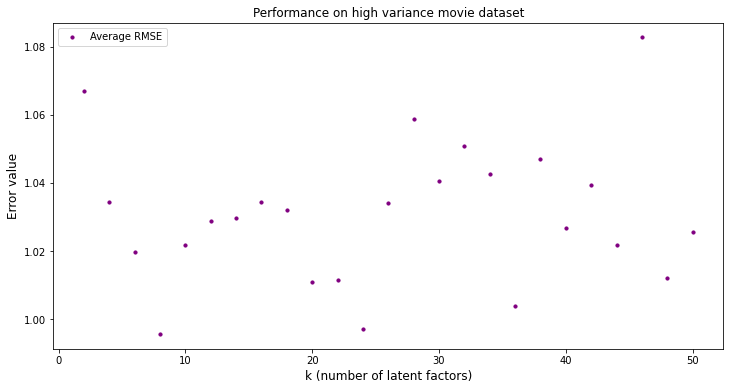

In [ ]:
print("Minimum average RSME is : ", min(rmse_nmf_high))

print("\n")

plt.scatter(k_value, rmse_nmf_high, label='Average RMSE', color="purple", s = 10)


plt.xlabel('k (number of latent factors)',fontsize=12)

plt.ylabel('Error value',fontsize=12)

plt.title("Performance on high variance movie dataset")

plt.legend()

plt.show()

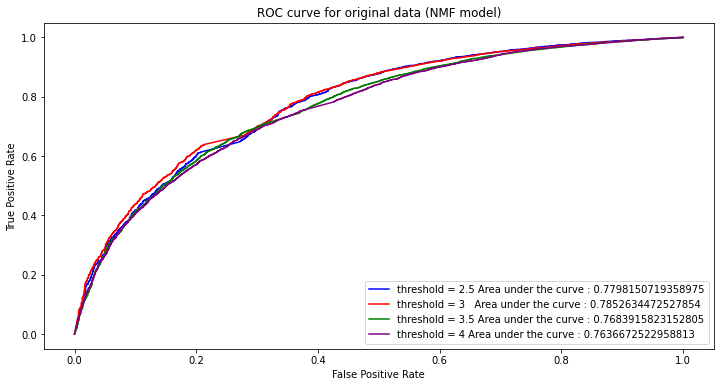

In [ ]:
# new change only y_true binary
df = pd.read_csv(movie_rating_file)

reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df[["userId", "movieId", "rating"]], reader)
train_data, test_data = train_test_split(data, test_size=0.1)

nmf = NMF(n_factors=20)
predict = nmf.fit(train_data).test(test_data)

color = ['blue','red','green','purple']
label = ['threshold = 2.5', 'threshold = 3  ', 'threshold = 3.5', 'threshold = 4']
title = 'ROC curve for original data (NMF model)'

j=0

for threshold in [2.5, 3, 3.5, 4]:

  y_true_labels = []

  y_scores = []

  for i in predict:
    y_true_labels.append(filter_rating(rating=i[2], threshold = threshold))
    y_scores.append(i[3])

  plot_ROC_curve(y_true_labels, y_scores, title=title, label=label[j], color=color[j], pos_label=2)
  j=j+1


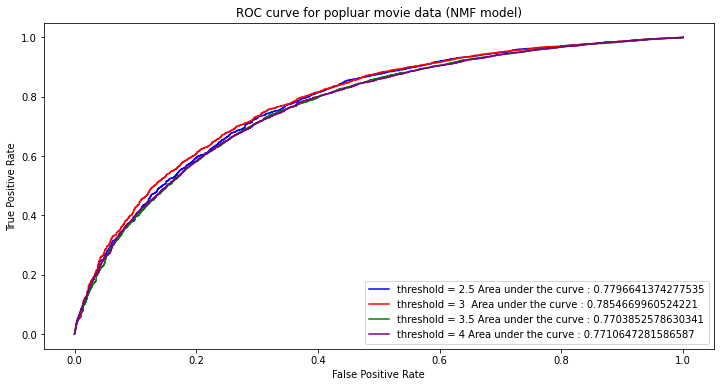

In [ ]:
#### popluar data (pop_movie_df)

reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(pop_movie_df[["userId", "movieId", "rating"]], reader)

train_data, test_data = train_test_split(data, test_size=0.1)

nmf = NMF(n_factors=20)

predict = nmf.fit(train_data).test(test_data)

color = ['blue','red','green','purple']
label = ['threshold = 2.5', 'threshold = 3 ', 'threshold = 3.5', 'threshold = 4']
title ='ROC curve for popluar movie data (NMF model)'

j=0

for threshold in [2.5, 3, 3.5, 4]:

  y_true_labels = []

  y_scores = []

  for i in predict:
    y_true_labels.append(filter_rating(rating=i[2], threshold = threshold))
    y_scores.append(i[3])

  plot_ROC_curve(y_true_labels, y_scores, title=title, label=label[j], color=color[j], pos_label=2)
  j=j+1

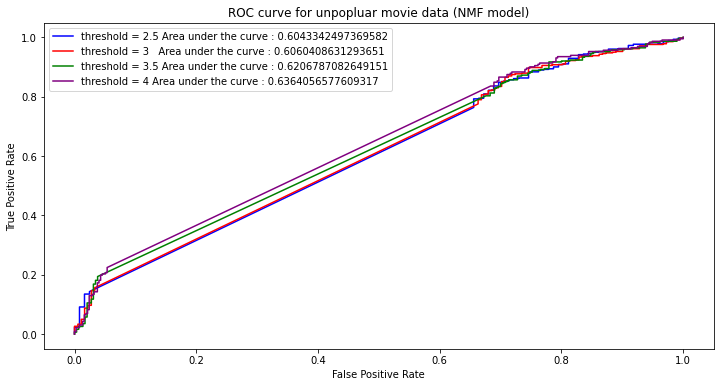

In [ ]:
#### unpopluar data (unpop_movie_df)

reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(unpop_movie_df[["userId", "movieId", "rating"]], reader)
train_data, test_data = train_test_split(data, test_size=0.1)

nmf = NMF(n_factors=20)

predict = nmf.fit(train_data).test(test_data)

color = ['blue','red','green','purple']
label = ['threshold = 2.5', 'threshold = 3  ', 'threshold = 3.5', 'threshold = 4']
title ='ROC curve for unpopluar movie data (NMF model)'

j=0

for threshold in [2.5, 3, 3.5, 4]:
  
  y_true_labels = []

  y_scores = []

  for i in predict:
    y_true_labels.append(filter_rating(rating=i[2], threshold = threshold))
    y_scores.append(i[3])

  plot_ROC_curve(y_true_labels, y_scores, title=title, label=label[j], color=color[j], pos_label=2)
  j=j+1

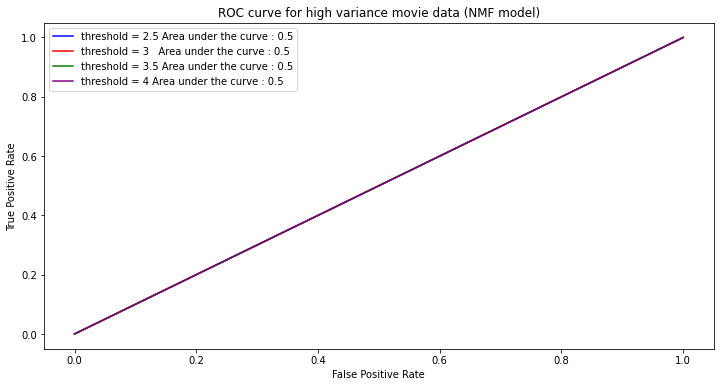

In [ ]:
#### high data (high_movie_df)

reader = Reader(rating_scale=(0, 5))

data = Dataset.load_from_df(high_movie_df[["userId", "movieId", "rating"]], reader)

train_data, test_data = train_test_split(data, test_size=0.1)

nmf = NMF(n_factors=20)
predict = nmf.fit(train_data).test(test_data)

color = ['blue','red','green','purple']
label = ['threshold = 2.5', 'threshold = 3  ', 'threshold = 3.5', 'threshold = 4']
title ='ROC curve for high variance movie data (NMF model)'

j=0

for threshold in [2.5, 3, 3.5, 4]:

  y_true_labels = []

  y_scores = []

  for i in predict:
    y_true_labels.append(filter_rating(rating=i[2], threshold = threshold))
    y_scores.append(i[3])

  try: 
    plot_ROC_curve(y_true_labels, y_scores, title=title, label=label[j], color=color[j], pos_label=2)
  except ValueError:
    pass
  j=j+1

Interpretability of NMF

In [ ]:
# NMF on rating matrix

df = pd.read_csv(movie_rating_file)
movie_df = pd.read_csv(movie_genre_file)


reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df[["userId", "movieId", "rating"]], reader)

nmf = NMF(n_factors=20)

train_data, test_data = train_test_split(data, test_size=0.1)
#trainset = data.build_full_trainset()
#nmf.fit(trainset)

nmf.fit(train_data)
U = nmf.pu
V = nmf.qi

In [ ]:
sort_index = V.argsort(axis=0)[::-1] #descending order

sort_index_trans= np.transpose(sort_index)

#print(sort_index_trans)

top_10 = sort_index_trans[:, :10]

#print(top_10)

In [ ]:
for row, col in enumerate(top_10):
    print('Genres of the top 10 movies in column No.', row+1)
    j=0
    for i in col:
        j=j+1
        movie_genres = movie_df['genres'][i].split('|')
        print(' Top', j,":", movie_genres)
    print("\n")


Genres of the top 10 movies in column No. 1
 Top 1 : ['Children', 'Comedy', 'Drama', 'Mystery']
 Top 2 : ['Drama', 'Romance']
 Top 3 : ['Crime', 'Drama']
 Top 4 : ['Comedy']
 Top 5 : ['Drama']
 Top 6 : ['Comedy', 'Horror', 'Musical']
 Top 7 : ['Comedy', 'Drama', 'Romance']
 Top 8 : ['Comedy', 'Drama', 'Romance']
 Top 9 : ['Drama']
 Top 10 : ['Action', 'Adventure', 'Animation', 'Children']


Genres of the top 10 movies in column No. 2
 Top 1 : ['Drama']
 Top 2 : ['Action', 'Drama', 'Sci-Fi', 'Thriller']
 Top 3 : ['Drama']
 Top 4 : ['Comedy', 'Romance']
 Top 5 : ['Drama']
 Top 6 : ['Documentary']
 Top 7 : ['Action']
 Top 8 : ['Drama', 'War']
 Top 9 : ['Drama']
 Top 10 : ['Drama']


Genres of the top 10 movies in column No. 3
 Top 1 : ['Drama', 'Romance']
 Top 2 : ['Comedy', 'Drama']
 Top 3 : ['Comedy', 'Drama', 'Fantasy', 'Romance']
 Top 4 : ['Comedy', 'Drama', 'War']
 Top 5 : ['Action', 'Adventure', 'Fantasy', 'Romance', 'IMAX']
 Top 6 : ['Action', 'Drama']
 Top 7 : ['Adventure', 'Anima

# Matrix factorization with bias (MF with bias)

In [ ]:
df = pd.read_csv(movie_rating_file)

reader = Reader(rating_scale=(0, 5))

data = Dataset.load_from_df(df[["userId", "movieId", "rating"]], reader)

In [ ]:
# sweep k in 10-fold cv

k_value = np.arange(2, 51, 2)

#kf = KFold(n_splits = 10) 

rmse_mfb = []

mae_mfb = []


for k in k_value:
  algo = SVD(n_factors=k, biased=True)
  cv_10f = cross_validate(algo=algo, data=data, measures=['rmse', 'mae'], cv=10, verbose=False)
  rmse_mfb.append(cv_10f['test_rmse'].mean())
  mae_mfb.append(cv_10f['test_mae'].mean())


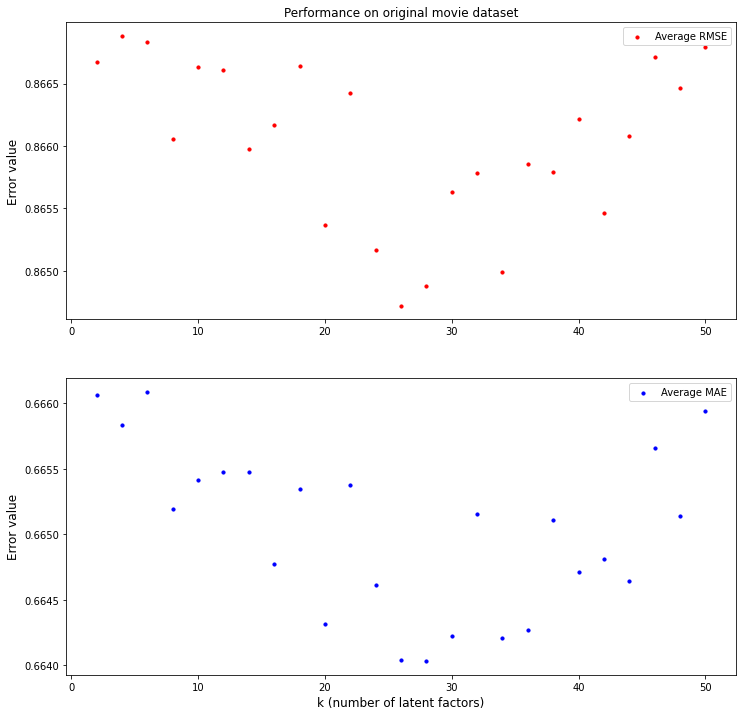

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,
                               #sharex=True, 
                               figsize=(12, 12)
                              )

ax1.scatter(k_value, rmse_mfb, label='Average RMSE', color="red", s = 10)

ax2.scatter(k_value, mae_mfb, label='Average MAE', color="blue", s = 10)

plt.xlabel('k (number of latent factors)',fontsize=12)

ax1.set_ylabel('Error value', fontsize = 12)
ax2.set_ylabel('Error value', fontsize = 12)


ax1.set(title = "Performance on original movie dataset")

ax1.set(title = "Performance on original movie dataset")

ax1.legend()
ax2.legend()
plt.show()


In [ ]:
#optimal k based on rsme
for i in range (len(rmse_mfb)):
  if rmse_mfb[i] == min(rmse_mfb):
    k_opt = k_value[i]

print("The optimal number of latent factors (based on RSME) is: ",k_opt)


#optimal k based on mae
for i in range (len(mae_mfb)):
  if mae_mfb[i] == min(mae_mfb):
    k_opt = k_value[i]


print("The optimal number of latent factors (based on MAE) is: ",k_opt)


The optimal number of latent factors (based on RSME) is:  26
The optimal number of latent factors (based on MAE) is:  28


In [ ]:
# sweep k in 10-fold cv.  popular movie
k_value = np.arange(2, 51, 2)

#kf = KFold(n_splits = 10) 

rmse_mfb_pop = []



for k in k_value:
  algo = SVD(n_factors=k, biased=True)
  cv_10f = cross_validate(algo=algo, data=pop_movie_data, measures=['rmse'], cv=10, verbose=False)
  rmse_mfb_pop.append(cv_10f['test_rmse'].mean())


Minium average RSME is :  0.855425150473684




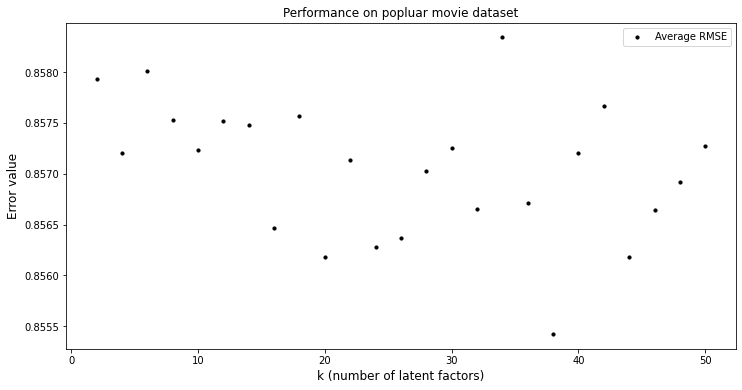

In [ ]:
print("Minimum average RSME is : ", min(rmse_mfb_pop))

print("\n")

plt.scatter(k_value, rmse_mfb_pop, label='Average RMSE', color="black", s = 10)


plt.xlabel('k (number of latent factors)',fontsize=12)

plt.ylabel('Error value',fontsize=12)

plt.title("Performance on popluar movie dataset")

plt.legend()

plt.show()

In [ ]:
# sweep k in 10-fold cv.  unpopular movie
k_value = np.arange(2, 51, 2)

#kf = KFold(n_splits = 10) 

rmse_mfb_unpop = []



for k in k_value:
  algo = SVD(n_factors=k, biased=True)
  cv_10f = cross_validate(algo=algo, data=unpop_movie_data, measures=['rmse'], cv=10, verbose=False)
  rmse_mfb_unpop.append(cv_10f['test_rmse'].mean())


Minium average RSME is :  0.8940091972795013




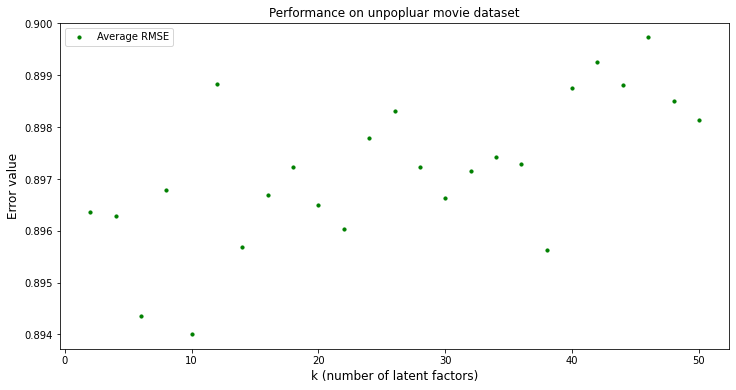

In [ ]:
print("Minimum average RSME is : ", min(rmse_mfb_unpop))

print("\n")

plt.scatter(k_value, rmse_mfb_unpop, label='Average RMSE', color="green", s = 10)


plt.xlabel('k (number of latent factors)',fontsize=12)

plt.ylabel('Error value',fontsize=12)

plt.title("Performance on unpopluar movie dataset")

plt.legend()

plt.show()

In [ ]:
# sweep k in 10-fold cv.  high variance movie
k_value = np.arange(2, 51, 2)

#kf = KFold(n_splits = 10) 

rmse_mfb_high = []



for k in k_value:
  algo = SVD(n_factors=k, biased=True)
  cv_10f = cross_validate(algo=algo, data=high_movie_data, measures=['rmse'], cv=10, verbose=False)
  rmse_mfb_high.append(cv_10f['test_rmse'].mean())


Minium average RSME is :  0.9638052335213301




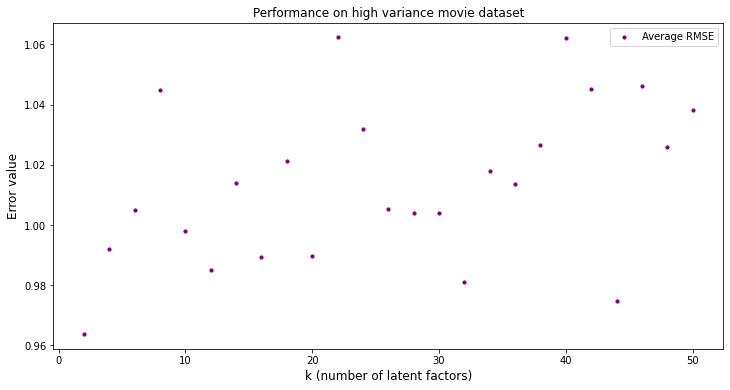

In [ ]:
print("Minimum average RSME is : ", min(rmse_mfb_high))

print("\n")

plt.scatter(k_value, rmse_mfb_high, label='Average RMSE', color="purple", s = 10)


plt.xlabel('k (number of latent factors)',fontsize=12)

plt.ylabel('Error value',fontsize=12)

plt.title("Performance on high variance movie dataset")

plt.legend()

plt.show()

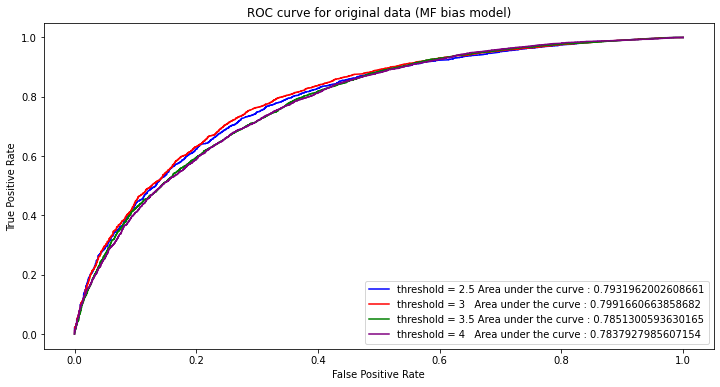

In [ ]:
df = pd.read_csv(movie_rating_file)

reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df[["userId", "movieId", "rating"]], reader)

train_data, test_data = train_test_split(data, test_size=0.1)

svd = SVD(n_factors=35, biased=True)
predict = svd.fit(train_data).test(test_data)



color = ['blue','red','green','purple']
label = ['threshold = 2.5', 'threshold = 3  ', 'threshold = 3.5', 'threshold = 4  ']
title = 'ROC curve for original data (MF bias model)'

j=0

for threshold in [2.5, 3, 3.5, 4]:
  
  y_true_labels = []

  y_scores = []

  for i in predict:
    y_true_labels.append(filter_rating(rating=i[2], threshold = threshold))
    y_scores.append(i[3])

  plot_ROC_curve(y_true_labels, y_scores, title=title, label=label[j], color=color[j], pos_label=2)
  j=j+1


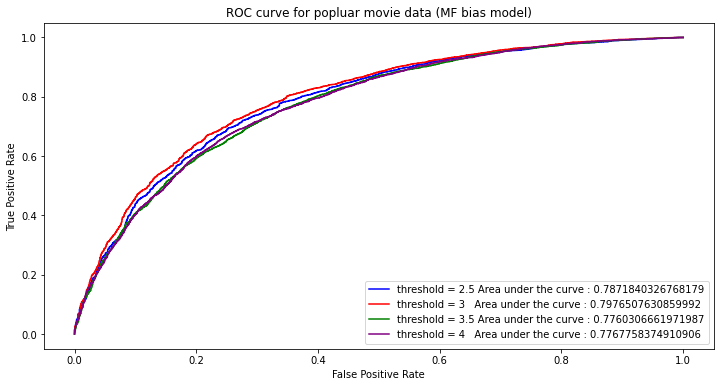

In [ ]:
#### popluar data (pop_movie_df)

reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(pop_movie_df[["userId", "movieId", "rating"]], reader)

train_data, test_data = train_test_split(data, test_size=0.1)

svd = SVD(n_factors=35, biased=True)
predict = svd.fit(train_data).test(test_data)


color = ['blue','red','green','purple']
label = ['threshold = 2.5', 'threshold = 3  ', 'threshold = 3.5', 'threshold = 4  ']
title ='ROC curve for popluar movie data (MF bias model)'

j=0

for threshold in [2.5, 3, 3.5, 4]:

  y_true_labels = []

  y_scores = []

  for i in predict:
    y_true_labels.append(filter_rating(rating=i[2], threshold = threshold))
    y_scores.append(i[3])

  plot_ROC_curve(y_true_labels, y_scores, title=title, label=label[j], color=color[j], pos_label=2)
  j=j+1

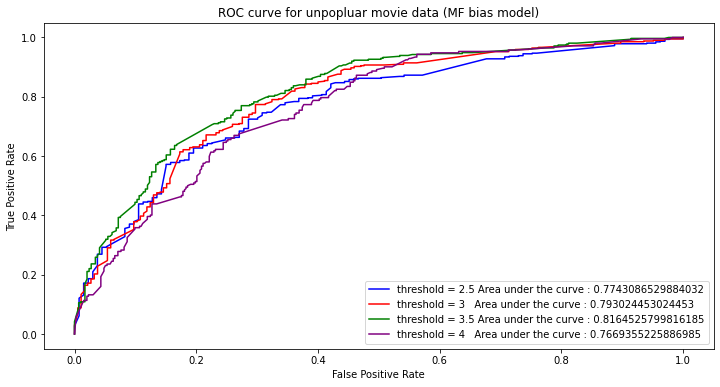

In [ ]:
#### unpopluar data (unpop_movie_df)

reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(unpop_movie_df[["userId", "movieId", "rating"]], reader)

train_data, test_data = train_test_split(data, test_size=0.1)

svd = SVD(n_factors=35, biased=True)
predict = svd.fit(train_data).test(test_data)


color = ['blue','red','green','purple']
label = ['threshold = 2.5', 'threshold = 3  ', 'threshold = 3.5', 'threshold = 4  ']
title ='ROC curve for unpopluar movie data (MF bias model)'

j=0

for threshold in [2.5, 3, 3.5, 4]:

  y_true_labels = []

  y_scores = []

  for i in predict:
    y_true_labels.append(filter_rating(rating=i[2], threshold = threshold))
    y_scores.append(i[3])

  plot_ROC_curve(y_true_labels, y_scores, title=title, label=label[j], color=color[j], pos_label=2)
  j=j+1

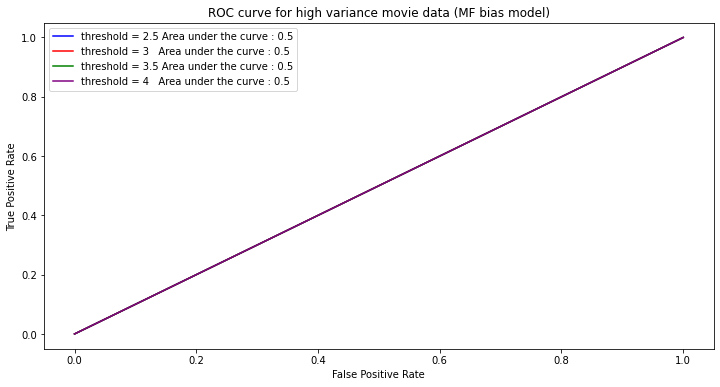

In [ ]:
#### high data (high_movie_df)

reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(high_movie_df[["userId", "movieId", "rating"]], reader)

train_data, test_data = train_test_split(data, test_size=0.1)

svd = SVD(n_factors=35, biased=True)
predict = svd.fit(train_data).test(test_data)

color = ['blue','red','green','purple']
label = ['threshold = 2.5', 'threshold = 3  ', 'threshold = 3.5', 'threshold = 4  ']
title ='ROC curve for high variance movie data (MF bias model)'

j=0

for threshold in [2.5, 3, 3.5, 4]:

  y_true_labels = []

  y_scores = []

  for i in predict:
    y_true_labels.append(filter_rating(rating=i[2], threshold = threshold))
    y_scores.append(i[3])

  try: 
    plot_ROC_curve(y_true_labels, y_scores, title=title, label=label[j], color=color[j], pos_label=2)
  except ValueError:
    pass
  j=j+1

# Naive collaborative filtering

In [ ]:
# directory = '/content/drive/My Drive/Project 3/Synthetic_Movie_Lens'

# rating = 'ratings.csv'

# movie_rating_file = os.path.join(directory, rating)

# df = pd.read_csv(movie_rating_file)
# reader = Reader(rating_scale=(0, 5))
# data = Dataset.load_from_df(df[["userId", "movieId", "rating"]], reader)

# knn = KNNWithMeans(k=20, sim_options={'name': 'pearson'})
# nmf = NMF(n_factors=20)
# mfb = SVD(n_factors=50, biased=True)

# train_data = data.build_full_trainset()

In [ ]:
popular_movie_df = trimming_popular_movie(df)
unpopular_movie_df = trimming_unpopular_movie(df)
high_variance_movie_df = trimming_high_variance_movie(df)

untrimmed_movie_data = dataframe_to_dataset(df)
popular_movie_date = dataframe_to_dataset(popular_movie_df)
unpopular_movie_date = dataframe_to_dataset(unpopular_movie_df)
high_variance_movie_date = dataframe_to_dataset(high_variance_movie_df)

datasets = [untrimmed_movie_data, popular_movie_date, unpopular_movie_date, high_variance_movie_date]

In [ ]:
kf = KFold(n_splits = 10)

data_trainset = data.build_full_trainset()
data_testset = data_trainset.build_testset()
all_movies = np.unique(np.array(df["movieId"]))

user_id_list = np.unique([i[0] for i in data_testset])

# calculate mean rating for all user
user_avg_rating = [None] * (len(user_id_list)+1)
for user_id in user_id_list:

  true_rating = [rating[2] for rating in data_testset if rating[0] == user_id]
  avg_rating = sum(true_rating)/len(true_rating)
  user_avg_rating[user_id] = avg_rating


# cross-validate and calculate RSME
avg_RSME_list = []
for dataset in datasets:
  RMSE_list = []
  for trainset, testset in kf.split(dataset):
    predictions = []
    for row in testset:
      current_pred = Prediction(uid=row[0], iid=row[1], r_ui=row[2], est=user_avg_rating[row[0]], details={})
      predictions.append(current_pred)
    RMSE_list.append(accuracy.rmse(predictions, verbose=False))
  avg_RSME = sum(RMSE_list)/len(RMSE_list)
  avg_RSME_list.append(avg_RSME)

In [ ]:
print("Average RSME for Original Data:", avg_RSME_list[0])
print("Average RSME for Popular Subset:", avg_RSME_list[1])
print("Average RSME for Unpopular Subset:", avg_RSME_list[2])
print("Average RSME for High Variance Subset:", avg_RSME_list[3])


Average RSME for Original Data: 0.9346543847132723
Average RSME for Popular Subset: 0.9323149727540322
Average RSME for Unpopular Subset: 0.9706604147083009
Average RSME for High Variance Subset: 0.8150759443083917


# Performance comparison

Computing the pearson similarity matrix...
Done computing similarity matrix.


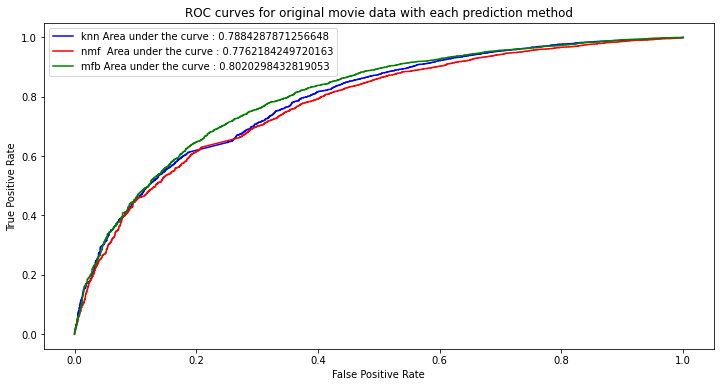

In [ ]:
df = pd.read_csv(movie_rating_file)
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df[["userId", "movieId", "rating"]], reader)

train_data, test_data = train_test_split(data, test_size=0.1)

threshold = 3

knn = KNNWithMeans(k=20, sim_options={'name': 'pearson'})
nmf = NMF(n_factors=20)
mfb = SVD(n_factors=35, biased=True)

predict = []
predict.append(knn.fit(train_data).test(test_data))
predict.append(nmf.fit(train_data).test(test_data))
predict.append(mfb.fit(train_data).test(test_data))

color = ['blue','red','green']
label = ['knn', 'nmf ', 'mfb']
title ='ROC curves for original movie data with each prediction method'

j=0


for x in label:

  y_true_labels = []
  y_scores = []

  for i in predict[j]:
    y_true_labels.append(filter_rating(rating=i[2], threshold = threshold))
    y_scores.append(i[3])

  plot_ROC_curve(y_true_labels, y_scores, title=title, label=label[j], color=color[j], pos_label=2)
  j=j+1

# Ranking

In [ ]:
# Precision_recall function from Surprise documentation

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        if len(user_ratings) < k or n_rel == 0:
          continue

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls


In [ ]:
# get precision_recall for three archietecture and sweep t from 1 to 25

kf = KFold(n_splits=10)

knn = KNNWithMeans(k=20, sim_options={'name': 'pearson'})
nmf = NMF(n_factors=20)
mfb = SVD(n_factors=35, biased=True)

knn_precision_list = []
knn_recall_list = []
for t in range(1, 26):

  precision_total = []
  recall_total = []

  for trainset, testset in kf.split(data):
      knn.fit(trainset)
      predictions = knn.test(testset)
      precisions, recalls = precision_recall_at_k(predictions, k=t, threshold=3)

      # Precision and recall can then be averaged over all users
      precision_total.append(sum(prec for prec in precisions.values()) / len(precisions))
      recall_total.append(sum(rec for rec in recalls.values()) / len(recalls))

  precision_avg = sum(precision_total)/len(precision_total)
  recall_avg = sum(recall_total)/len(recall_total)
  knn_precision_list.append(precision_avg)
  knn_recall_list.append(recall_avg)



nmf_precision_list = []
nmf_recall_list = []
for t in range(1, 26):

  precision_total = []
  recall_total = []

  for trainset, testset in kf.split(data):
      nmf.fit(trainset)
      predictions = nmf.test(testset)
      precisions, recalls = precision_recall_at_k(predictions, k=t, threshold=3)

      # Precision and recall can then be averaged over all users
      precision_total.append(sum(prec for prec in precisions.values()) / len(precisions))
      recall_total.append(sum(rec for rec in recalls.values()) / len(recalls))

  precision_avg = sum(precision_total)/len(precision_total)
  recall_avg = sum(recall_total)/len(recall_total)
  nmf_precision_list.append(precision_avg)
  nmf_recall_list.append(recall_avg)



mfb_precision_list = []
mfb_recall_list = []
for t in range(1, 26):

  precision_total = []
  recall_total = []

  for trainset, testset in kf.split(data):
      mfb.fit(trainset)
      predictions = mfb.test(testset)
      precisions, recalls = precision_recall_at_k(predictions, k=t, threshold=3)

      # Precision and recall can then be averaged over all users
      precision_total.append(sum(prec for prec in precisions.values()) / len(precisions))
      recall_total.append(sum(rec for rec in recalls.values()) / len(recalls))

  precision_avg = sum(precision_total)/len(precision_total)
  recall_avg = sum(recall_total)/len(recall_total)
  mfb_precision_list.append(precision_avg)
  mfb_recall_list.append(recall_avg)

t_list = []
for t in range(1,26):
  t_list.append(t)

## Plots for three architecture

KNN

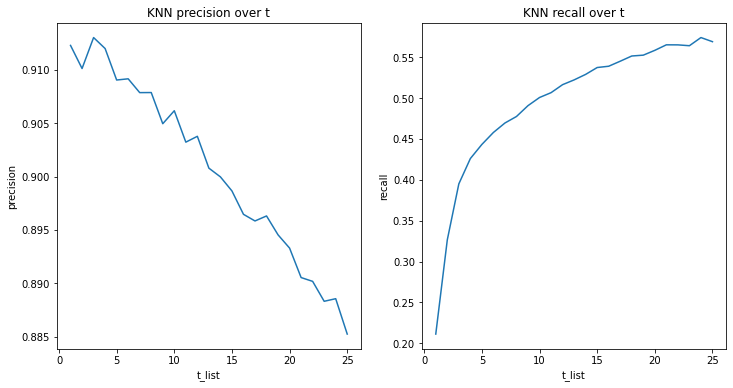

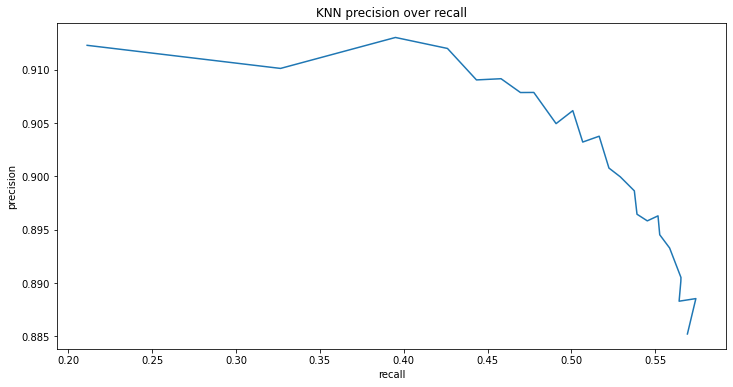

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2)

axs[0].plot(t_list, knn_precision_list)
axs[1].plot(t_list, knn_recall_list)


axs[0].set_xlabel('t_list')
axs[0].set_ylabel('precision')
axs[0].set_title('KNN precision over t')

axs[1].set_xlabel('t_list')
axs[1].set_ylabel('recall')
axs[1].set_title('KNN recall over t')

plt.show()

fig, axs = plt.subplots()
axs.plot(knn_recall_list, knn_precision_list)
axs.set_xlabel('recall')
axs.set_ylabel('precision')
axs.set_title('KNN precision over recall')

plt.show()

NMF

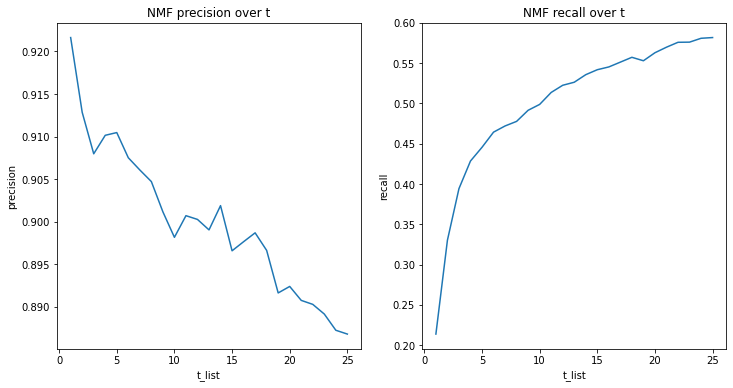

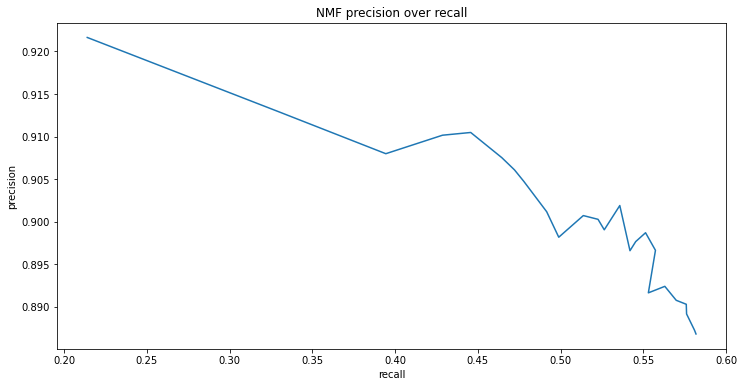

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2)

axs[0].plot(t_list, nmf_precision_list)
axs[1].plot(t_list, nmf_recall_list)


axs[0].set_xlabel('t_list')
axs[0].set_ylabel('precision')
axs[0].set_title('NMF precision over t')

axs[1].set_xlabel('t_list')
axs[1].set_ylabel('recall')
axs[1].set_title('NMF recall over t')

plt.show()

fig, axs = plt.subplots()
axs.plot(nmf_recall_list, nmf_precision_list)
axs.set_xlabel('recall')
axs.set_ylabel('precision')
axs.set_title('NMF precision over recall')

plt.show()

MFB

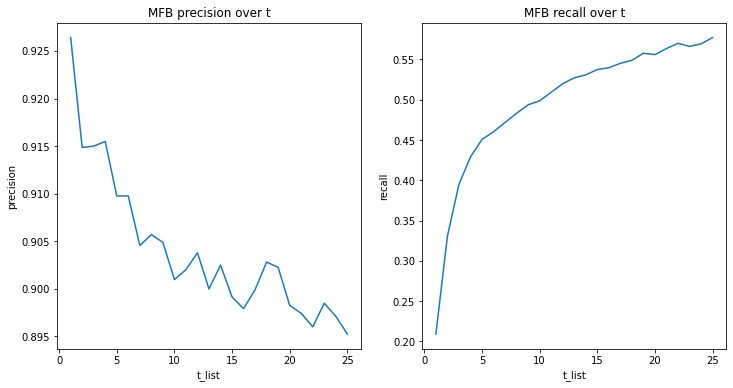

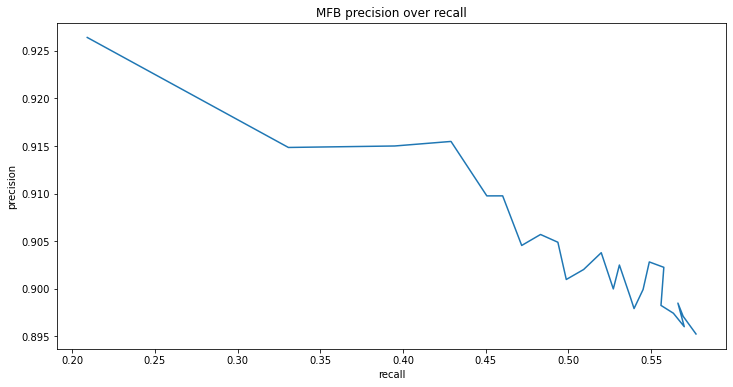

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2)

axs[0].plot(t_list, mfb_precision_list)
axs[1].plot(t_list, mfb_recall_list)


axs[0].set_xlabel('t_list')
axs[0].set_ylabel('precision')
axs[0].set_title('MFB precision over t')

axs[1].set_xlabel('t_list')
axs[1].set_ylabel('recall')
axs[1].set_title('MFB recall over t')

plt.show()

fig, axs = plt.subplots()
axs.plot(mfb_recall_list, mfb_precision_list)
axs.set_xlabel('recall')
axs.set_ylabel('precision')
axs.set_title('MFB precision over recall')

plt.show()

## Precision_Recall plots in one figure


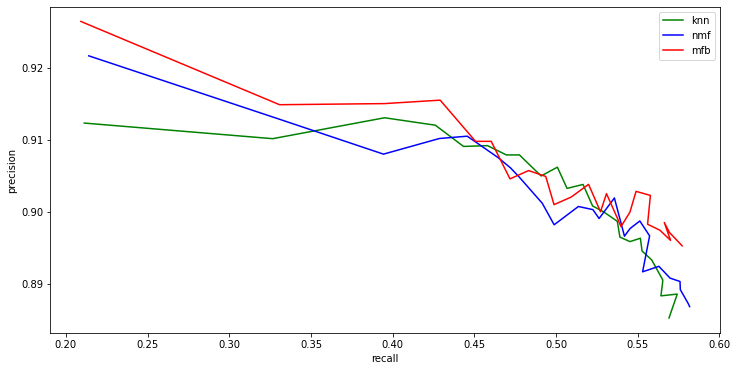

In [ ]:
plt.plot(knn_recall_list, knn_precision_list, color='green', label='knn')
plt.plot(nmf_recall_list, nmf_precision_list, color='blue', label='nmf')
plt.plot(mfb_recall_list, mfb_precision_list, color='red', label='mfb')

plt.legend()

plt.xlabel('recall')
plt.ylabel('precision')


plt.show()